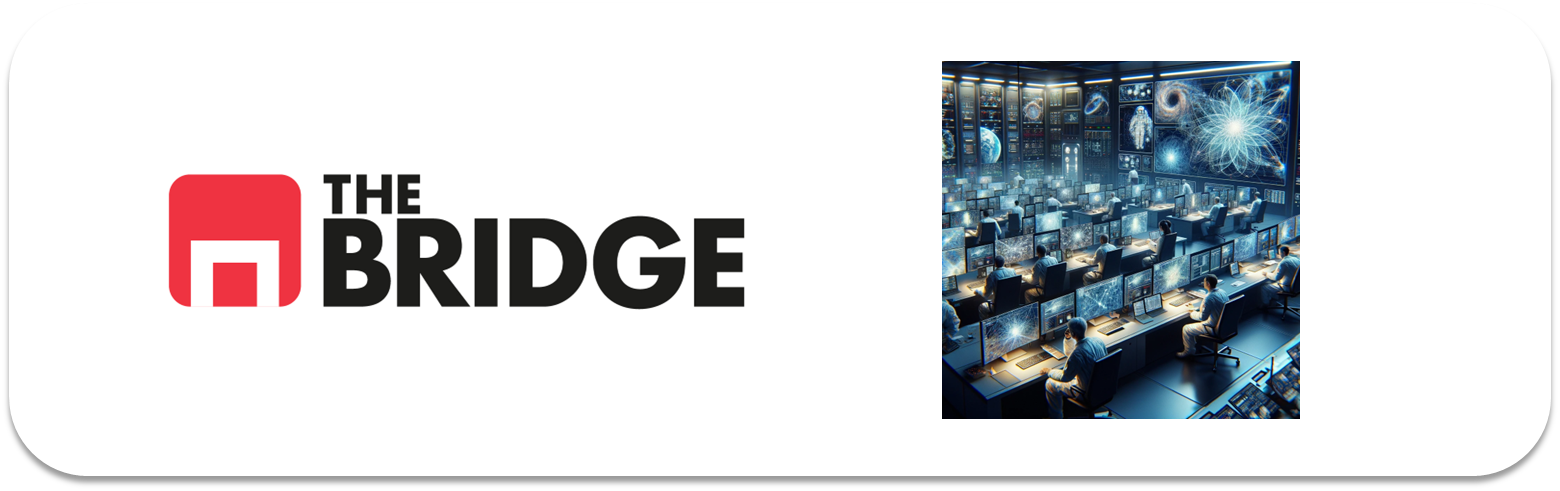

## PRACTICA OBLIGATORIA: **Redes Convolucionales**

* La práctica obligatoria de esta unidad consiste en un ejercicio de construcción de una red convolucional con Keras para la clasificación de imagenes de simpáticos perretes y gatetes. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import bootcampviztools as bt
from skimage.io import imread
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.optimizers import Adam
from tensorflow import keras
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

### Problema de Negocio y dataset

Una conocida empresa de información inmobiliaria utiliza un CAPTCHA visual de perros y gatos para detectar webscrappings intensivos y ataques de denegación de servicio. Últimamente, ha detectado que su sistema está empezando a flojear, es decir que hay muchos sistemas de detección automática de imágenes que son capaces de detectar que es un perro y un gato y salterse el CAPTCHA antirobots. Por eso nos ha pedido que entrenemos un modelo potente de clasificación que emule a estos sistemas con el objetivo de emplear como fotografías para el CAPTCHA aquellas que no sepa detectar este sistema emulador de chicos malos.  

Pues manos a la obra, tenemos que seleccionar en un conjunto de 1000 imágenes aquellas que peor se le daría clasificar a un potencial sistema anti-CAPTCHA.  

Para ello vamos a emplear un conjunto de train de 4000 imágenes de perretes y gatetes que se encuentran distribuidas en "data" en cuatro directorios "github_train_0",  "github_train_1", "githun_train_2" y "github_train_3". Los datos de las imagenes que tenemos que clasificar y luego seleccionar como las más "difíciles" están en "data" en el directorio "github_test".


### Se pide

1. Crear los datasets X,y de train y test, leyendo las imágenes de los directorios correspondientes (tendrás que leer todas las imágenes de los cuatro directorios para train) y a la vez que se leen adpatar su resolución para que todas tengan un tamaño de 32x32. En este caso puedes adaptar las funciones de los ejercicios de la unidad. NOTA: Ten en cuenta que la clase a la que pertenece en la foto está en el nombre del archivo.

2. Crea un modelo DL basado en redes convolucionales con al menos dos juegos Convolucional-Pooling. Sigue todo el proceso de ML (visualización del dataset, MiniEDA, Construcción del modelo)

3. Entrenar el modelo con un callback de Earlystopping con paciencia la que tengas :-). Muestra su historial de entrenamiento.

4. Evalua el modelo, haz un reporte de clasificacion y muestra la matriz de confianza.

5. Es el momento de seleccionar las imagenes: Selecciona el 10% de imágenes mal clasificadas de una y otra clase que tengan el mayor nivel de confianza de que pertenencían a la clase errónea. Es decir las imágenes de perros clasificadas como gatos y con la probabilidad de ser perror más alta.


### Extra (para hacer en clase)

Repite los pasos 3 a 5 utilizando el generador de imágenes sintéticas o Image Augmentation de Keras. 



#### Datasets 

Datasets X,y de train y test. Adpatar su resolución para que todas tengan un tamaño de 32x32.

In [2]:
ROOT_PATH = './data/'
TRAIN_PATH = ROOT_PATH + "train/"
TEST_PATH = ROOT_PATH + "test/"

In [3]:
X_train1, y_train1 = bt.read_data(TRAIN_PATH, (32,32))
X_test1,  y_test1 = bt.read_data(TEST_PATH, (32,32))

In [4]:
print(f"Dataset entrenamiento:{X_train1.shape}, {X_train1.size}")
print(f"Dataset testeo:{X_test1.shape}, {X_test1.size}")

Dataset entrenamiento:(4000, 32, 32, 3), 12288000
Dataset testeo:(1000, 32, 32, 3), 3072000


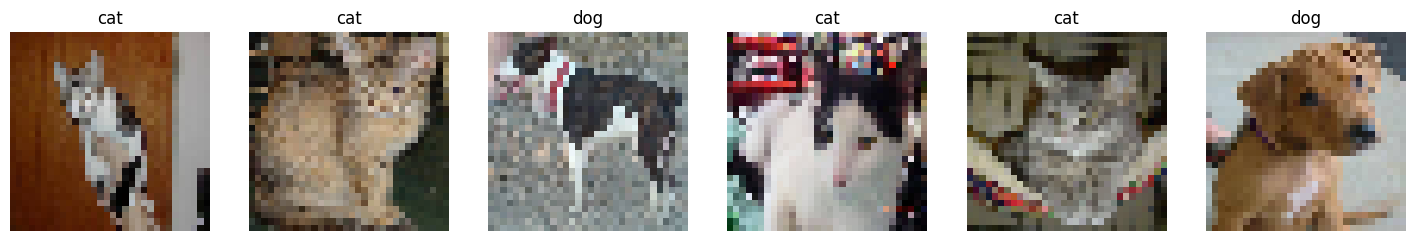

In [5]:
imagenes = [1708, 1345, 3313, 1178, 1080, 2049]
bt.show_images(X_train1[imagenes], y_train1[imagenes])

#### MiniEDA

In [6]:
target = pd.Series(y_train1)
target.value_counts(True)

cat    0.5
dog    0.5
Name: proportion, dtype: float64

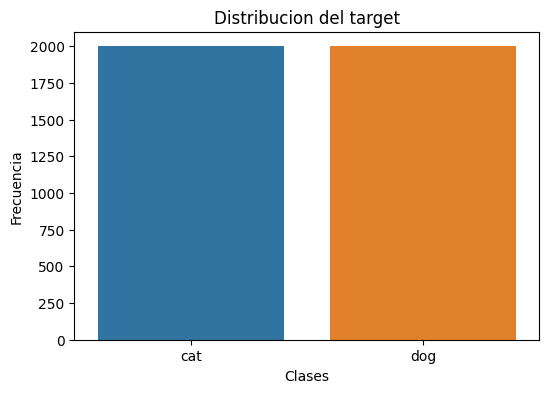

In [7]:
plt.figure(figsize=(6,4))
sns.countplot(x=target, order=target.value_counts().index, hue=target)
plt.title("Distribucion del target")
plt.xlabel("Clases")
plt.ylabel("Frecuencia")
plt.show()

Esta equilibrado

#### Normalizamos

In [8]:
X_train = X_train1/255
X_test = X_test1/255

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train1)
y_test = encoder.fit_transform(y_test1)

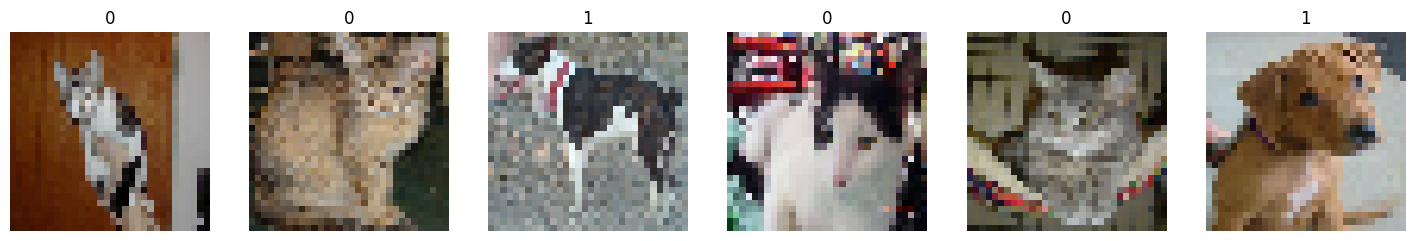

In [9]:
imagenes = [1708, 1345, 3313, 1178, 1080, 2049]
bt.show_images(X_train[imagenes], y_train[imagenes])

#### Modelo 

Crea un modelo DL basado en redes convolucionales con al menos dos juegos Convolucional-Pooling. Sigue todo el proceso de ML (visualización del dataset, MiniEDA, Construcción del modelo)

In [23]:
#API version 
input_layer = Input(shape=(32, 32, 3))   #input layer #32x32x3pixeles
conv2d_1 = Conv2D(filters=16, kernel_size=(7,7), padding='same', 
                  activation="relu")(input_layer)   #stride1x1 # 8filtros, kernel7x7(low resol) #convolucional-pooling layers 
pool_1 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(conv2d_1 )#capa pooling
drop_1 = Dropout(0.25)(pool_1) #rate:25%#capa dropout 
conv2d_2 = Conv2D(filters=32, kernel_size=(5,5), padding='same', activation="relu")(drop_1)#otra capa convolution 
pool_2 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(conv2d_2)
conv2d_3 = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation="relu")(pool_2)#otra capa convolution 
pool_3 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(conv2d_3)
drop_2  = Dropout(0.25)(pool_3)

flatten_layer = Flatten()(drop_2) #capa de aplanamiento 
hidden_1 = Dense(400,  activation = "relu")(flatten_layer)
hidden_2 = Dense(250, activation = "relu")(hidden_1)
output = Dense(1, activation="sigmoid")(hidden_2) #2 clases (dog, cat), entonces sigmoide
#output = Dense(1, activation="softmax")(hidden_2) 

model = keras.Model(inputs = [input_layer], outputs = [output])

##### Optimizador y compliador

In [24]:
optimizer = Adam(learning_rate =0.01, beta_1=0.9, beta_2=0.999) # > millón datos -->"Adam"
model.compile(optimizer = optimizer,
              loss = "binary_crossentropy", #clasificador binario
              metrics=["accuracy"])

In [25]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 32, 32, 16)          │           2,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 16, 16, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 16, 16, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 16, 16, 32)          │          12,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 8, 8, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 400)                 │         410,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 250)                 │         100,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │             251 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 544,197 (2.08 MB)

 Trainable params: 544,197 (2.08 MB)

 Non-trainable params: 0 (0.00 B)

 #### Entrenamiento 

Entrenar el modelo con un callback de Earlystopping.

In [26]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("callback_catdog_model.keras") 
early_stopping_cb = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)

history = model.fit(
    X_train,
    y_train,
    batch_size=256,
    epochs=80,
    validation_split=0.2,   # agreagamos la validacion 
    shuffle=True,            # split es aleatorio
    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.5255 - loss: 5.6045 - val_accuracy: 0.0000e+00 - val_loss: 0.8623
Epoch 2/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.6267 - loss: 0.6637 - val_accuracy: 0.0000e+00 - val_loss: 0.9422
Epoch 3/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.6255 - loss: 0.6620 - val_accuracy: 0.0000e+00 - val_loss: 0.9960
Epoch 4/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.6194 - loss: 0.6647 - val_accuracy: 0.0000e+00 - val_loss: 0.9828
Epoch 5/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.6270 - loss: 0.6610 - val_accuracy: 0.0000e+00 - val_loss: 0.9899
Epoch 6/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.6172 - loss: 0.6660 - val_accuracy: 0.0000e+00 - val_loss: 0.9548
Epoch 7/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.6389 - loss: 0.6558 - val_accuracy: 0.0000e+00 - val_loss: 0.9670
Epoch 8/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.6108 - loss: 0.6

In [27]:
print(history.params)
print(history.epoch)

{'verbose': 'auto', 'epochs': 80, 'steps': 13}
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


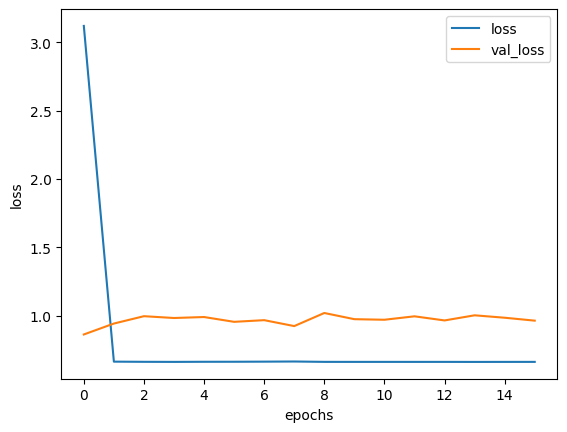

In [28]:
history_df = pd.DataFrame(history.history)
history_df[["loss","val_loss"]].plot();
plt.xlabel("epochs")
plt.ylabel("loss");

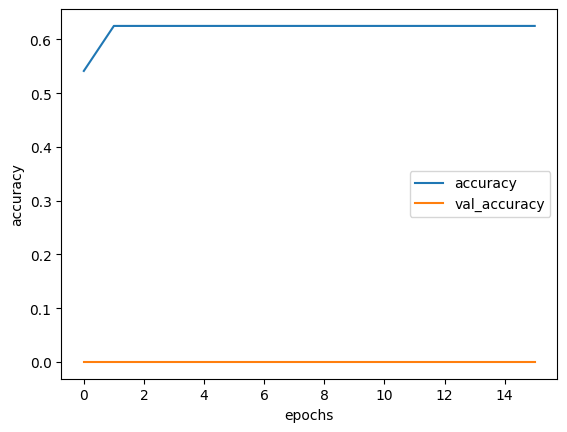

In [29]:
history_df = pd.DataFrame(history.history)
history_df[["accuracy","val_accuracy"]].plot();
plt.xlabel("epochs")
plt.ylabel("accuracy");

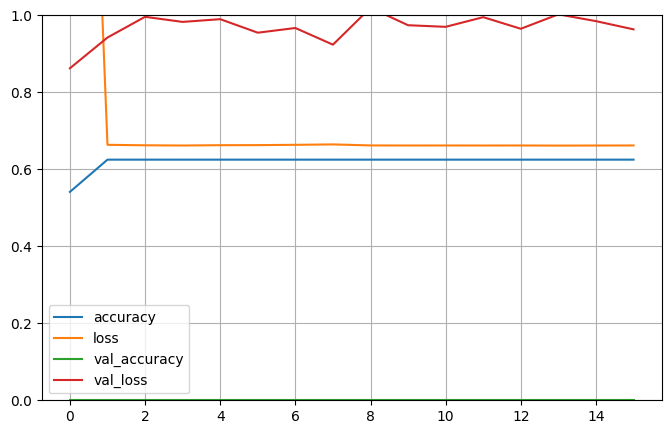

In [30]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

#### Evaluacion del modelo 
Evalua el modelo, haz un reporte de clasificacion y muestra la matriz de confianza.

In [31]:
results = model.evaluate(X_test, y_test)
print(f"test loss: {np.round(results[0],4)}, test acc:{np.round(results[1],4)}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8206 - loss: 0.6048 
test loss: 0.7054, test acc:0.5


In [32]:
y_pred = [np.argmax(prediction) for prediction in  model.predict(X_test)]
print(classification_report(y_test,y_pred))

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       500
           1       0.00      0.00      0.00       500

    accuracy                           0.50      1000
   macro avg       0.25      0.50      0.33      1000
weighted avg       0.25      0.50      0.33      1000



C:\Users\lupev\AppData\Local\r-miniconda\envs\jupyter-env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lupev\AppData\Local\r-miniconda\envs\jupyter-env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lupev\AppData\Local\r-miniconda\envs\jupyter-env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

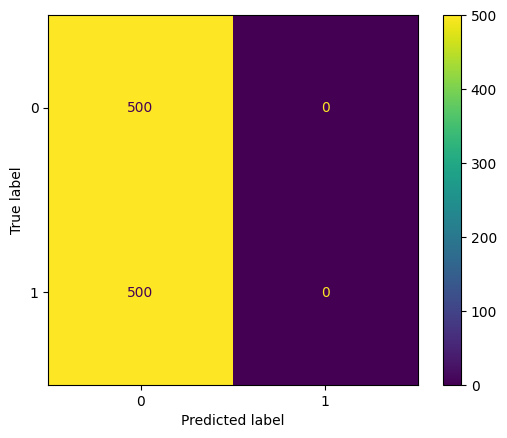

In [33]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred);

In [34]:
model.save("cat_dog_model.keras")

Es el momento de seleccionar las imagenes: Selecciona el 10% de imágenes mal clasificadas de una y otra clase que tengan el mayor nivel de confianza de que pertenencían a la clase errónea. Es decir las imágenes de perros clasificadas como gatos y con la probabilidad de ser perror más alta.

In [35]:
y_pred_proba = model.predict(X_test)
y_pred_class = (y_pred_proba > 0.5).astype(int).flatten()   # binary
mis_indx = np.where(y_pred_class != y_test)[0]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


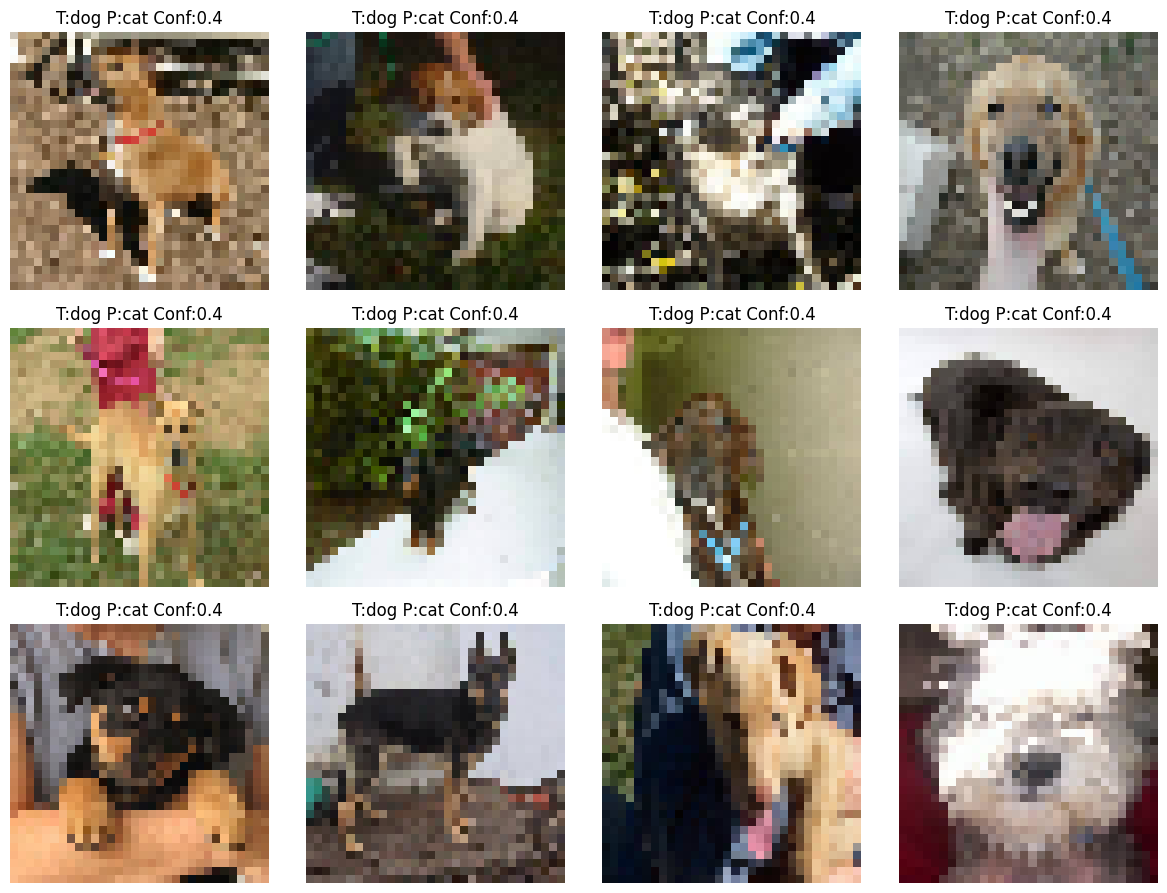

In [36]:
misclassified_img = bt.misclassified_images(y_test, y_pred_class, y_pred_proba, mis_indx)
bt.plot_misclassified(X_test, y_test1, misclassified_img, y_pred_proba,y_pred_class, 12)